In [ ]:
!pip install noise

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import cv2
from skimage.util import random_noise
import os
import shutil

from noise import pnoise2  # Perlin noise

In [2]:
import seaborn as sns

def color_labels(label, max_id = 40):
    colored_label = np.zeros((label.shape[0], label.shape[1], 3))
    colors = sns.color_palette("CMRmap", max_id)
    for i in range(0, max_id):
        colored_label[label == i] = colors[i]
    return colored_label

In [3]:
def generate_random_img(W, H, num_gaussians=10, noise_level=0.2):
    # Generate a grid of coordinates
    x = np.linspace(-3, 3, W)
    y = np.linspace(-3, 3, H)
    X, Y = np.meshgrid(x, y)

    # Generate random Gaussians
    gaussians = []
    for _ in range(num_gaussians):
        x0 = np.random.uniform(-3, 3)
        y0 = np.random.uniform(-3, 3)
        sigma = np.random.uniform(0.1, 1.0)
        gaussian = np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
        gaussians.append(gaussian)

    # Combine random Gaussians and other patterns
    image = np.sum(gaussians, axis=0)
    image += np.random.rand(H, W) * noise_level  # Add some random noise

    # Normalize the image to [0, 1]
    image -= np.min(image)
    image /= np.max(image)

    return image

In [4]:
# Function to generate a circle with smooth random bumps
def generate_amoeba_shape(size, num_points = 50, seed=42):
    img = np.zeros((size, size), dtype=np.uint8)
    center = (size // 2, size // 2)  # Center of the image
    radius = size // 5  # Radius of the circle

    num_pts = num_points  # Number of points around the circle
    pts = []

    for i in range(num_pts):
        angle = 2 * math.pi * i / num_pts
        x = int(center[0] + radius * math.cos(angle))
        y = int(center[1] + radius * math.sin(angle))

        # Generate smooth offset using Perlin noise
        noise_val = pnoise2(x / num_points, y / num_points, octaves=6, persistence=0.5, lacunarity=2.0, repeatx=1024, repeaty=1024, base=seed)
        offset = int(noise_val * size)  # Scale the noise to control the amount of variation

        x += offset
        y += offset

        pts.append([x, y])

    # Draw polygon
    cv2.fillPoly(img, [np.array(pts)], 255)

    return img

#Image rolling with custom paddig
#Source: https://stackoverflow.com/questions/2777907/python-numpy-roll-with-padding
def shift_2d_replace(data, dx, dy, constant=False):
  """
  Shifts the array in two dimensions while setting rolled values to constant
  :param data: The 2d numpy array to be shifted
  :param dx: The shift in x
  :param dy: The shift in y
  :param constant: The constant to replace rolled values with
  :return: The shifted array with "constant" where roll occurs
  """
  shifted_data = np.roll(data, dx, axis=1)
  if dx < 0:
    shifted_data[:, dx:] = constant
  elif dx > 0:
    shifted_data[:, 0:dx] = constant

  shifted_data = np.roll(shifted_data, dy, axis=0)
  if dy < 0:
    shifted_data[dy:, :] = constant
  elif dy > 0:
    shifted_data[0:dy, :] = constant
  return shifted_data

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def overlay_mask(image, mask, px, py, color):
    xx, yy = np.shape(mask)
    img_mask = np.zeros_like(image)
    img_mask[0:xx,0:yy]=mask
    img_mask = shift_2d_replace(img_mask, int(px-xx//2), int(py-yy//2), constant=0)
    image[img_mask != 0] = color
    return image

In [5]:
class SyntheticAmoeboids:
  def __init__(self, WW = 1024, HH = 1024, W = 512, H = 512, init_objects = 40, min_diameter = 60, max_diameter = 80, speed_coeff = 0.4, rot_coeff = 1, max_aang = 10):
    self.WW = WW
    self.HH = HH
    self.W = W
    self.H = H
    self.min_diameter = min_diameter
    self.max_diameter = max_diameter
    self.rot_coeff = rot_coeff
    self.max_aang = max_aang
    self.max_id = 0
    self.background = generate_random_img(W,H)*100

    self.objects = []
    for i in range(init_objects):
      obj = {}
      obj['diameter'] = random.randint(self.min_diameter,self.max_diameter)
      while True:
        obj['mask'] = generate_amoeba_shape(obj['diameter'], seed=random.randint(0,1024**2))
        if np.sum(obj['mask']) >= min_diameter*min_diameter*math.pi/4:
          break
      obj['px'] = random.randint(-int((self.WW-self.W)/2)+obj['diameter'], self.W+int((self.WW-self.W)/2)-obj['diameter'])
      obj['py'] = random.randint(-int((self.HH-self.H)/2)+obj['diameter'], self.H+int((self.HH-self.H)/2)-obj['diameter'])
      obj['vx'] = random.randint(self.min_diameter, self.max_diameter) * speed_coeff * (-1 if random.random() < 0.5 else 1)
      obj['vy'] = random.randint(self.min_diameter, self.max_diameter) * speed_coeff * (-1 if random.random() < 0.5 else 1)
      obj['aang'] = 0
      obj['id'] = self.max_id
      obj['color'] = random.randint(100,255)
      self.max_id+=1
      self.objects.append(obj)

  def step(self):
    for i in range(len(self.objects)):

      #self.objects[i]['mask'] = modify_amoeboid_with_perlin_reduced(self.objects[i]['mask'], seed=random.randint(0,1024**2))

      aang_good = True
      if self.objects[i]['aang'] >= self.max_aang:
        self.objects[i]['aang'] += -(random.random())*self.rot_coeff
        aang_good = False
      if self.objects[i]['aang'] <= -self.max_aang:
        self.objects[i]['aang'] += (random.random())*self.rot_coeff
        aang_good = False
      if aang_good:
        self.objects[i]['aang'] += (random.random()*2-1)*self.rot_coeff

      #self.objects[i]['mask'] = rotate_image(self.objects[i]['mask'], self.objects[i]['aang'])

      theta_rad = math.radians(self.objects[i]['aang'])
      vx_new = self.objects[i]['vx'] * math.cos(theta_rad) - self.objects[i]['vy'] * math.sin(theta_rad)
      vy_new = self.objects[i]['vx'] * math.sin(theta_rad) + self.objects[i]['vy'] * math.cos(theta_rad)
      self.objects[i]['vx'] = vx_new
      self.objects[i]['vy'] = vy_new

      # Repulsion and collision detection
      for j in range(len(self.objects)):
        if i != j:
          dx = self.objects[j]['px'] - self.objects[i]['px']
          dy = self.objects[j]['py'] - self.objects[i]['py']
          distance = math.sqrt(dx ** 2 + dy ** 2)
          if distance < (self.objects[i]['diameter'] + self.objects[j]['diameter']) / 2:
            # Collided, move objects apart
            overlap = (self.objects[i]['diameter'] + self.objects[j]['diameter']) / 2 - distance
            if distance == 0:
              angle = math.atan2(dy, dx)
              dx = math.cos(angle) * overlap / 2
              dy = math.sin(angle) * overlap / 2
            else:
              dx *= overlap / (2 * distance)
              dy *= overlap / (2 * distance)
            self.objects[i]['px'] -= dx
            self.objects[i]['py'] -= dy
            self.objects[j]['px'] += dx
            self.objects[j]['py'] += dy

      if self.objects[i]['px'] < -int((self.WW-self.W)/2):
        self.objects[i]['vx'] = -self.objects[i]['vx']
      if self.objects[i]['py'] < -int((self.HH-self.H)/2):
        self.objects[i]['vy'] = -self.objects[i]['vy']
      if self.objects[i]['px'] > self.W+int((self.WW-self.W)/2):
        self.objects[i]['vx'] = -self.objects[i]['vx']
      if self.objects[i]['py'] > self.H+int((self.HH-self.H)/2):
        self.objects[i]['vy'] = -self.objects[i]['vy']

      self.objects[i]['px'] += self.objects[i]['vx']
      self.objects[i]['py'] += self.objects[i]['vy']

  def render(self):
    img = np.copy(self.background)
    label = np.zeros((self.W,self.H))
    for obj in self.objects:

      img = overlay_mask(img, np.array(obj["mask"], dtype=np.int32), obj['px'], obj['py'], color=obj['color'])
      label = overlay_mask(label, np.array(obj["mask"], dtype=np.int32), obj['px'], obj['py'], color=obj['id'])

    img = cv2.min(img+generate_random_img(self.W,self.H)*20, np.ones((self.W,self.H))*255)

    img = ((img - np.min(img)) / (np.max(img) - np.min(img))) * 255
    img = np.array(img, dtype='uint8')
    label = np.array(label, dtype='uint8')

    return img, label

In [9]:
init_objects = 40
arrows = SyntheticAmoeboids(init_objects = init_objects)

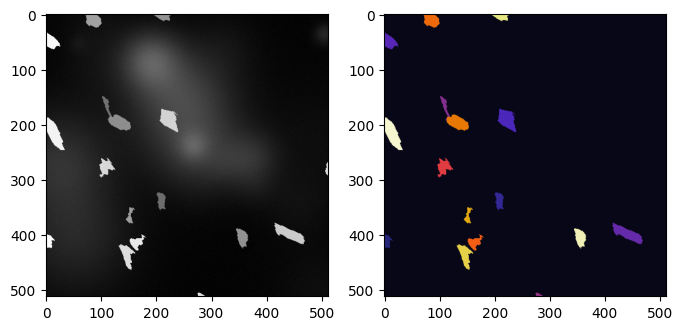

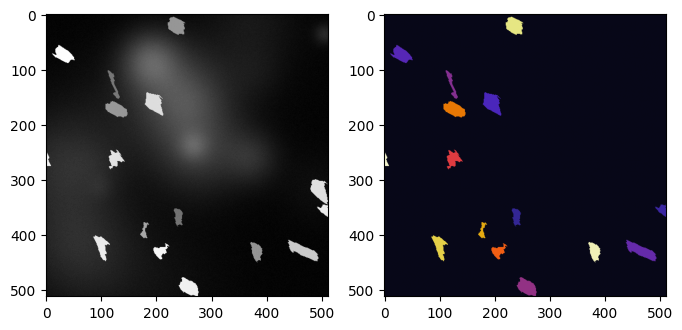

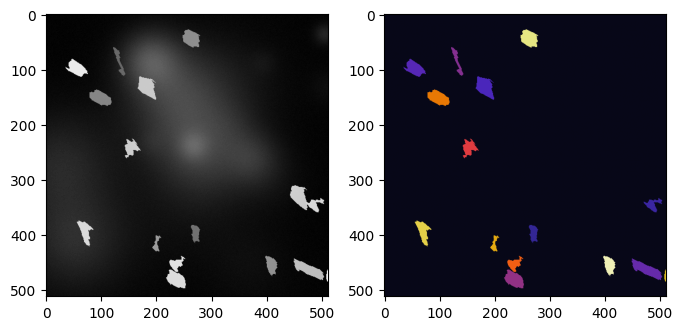

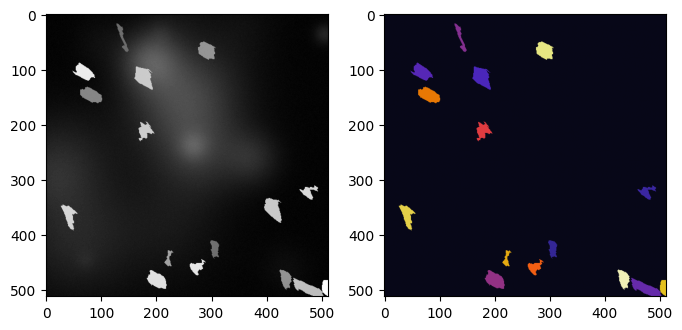

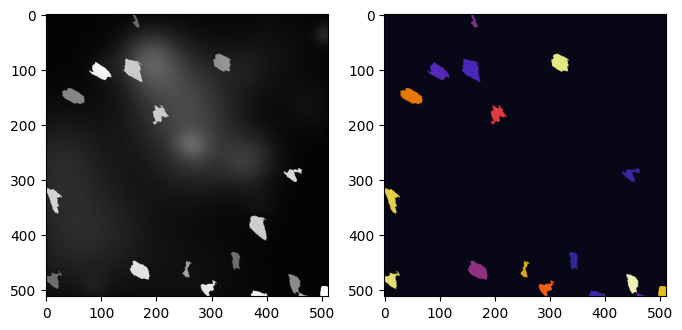

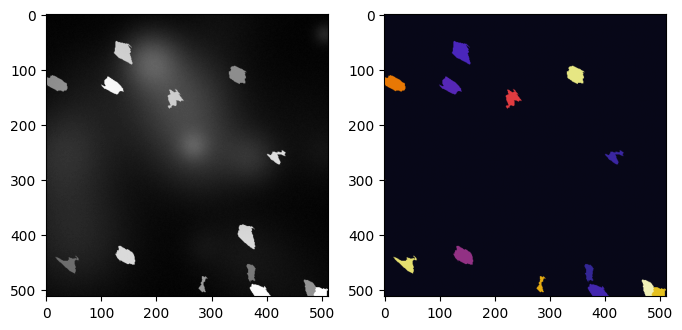

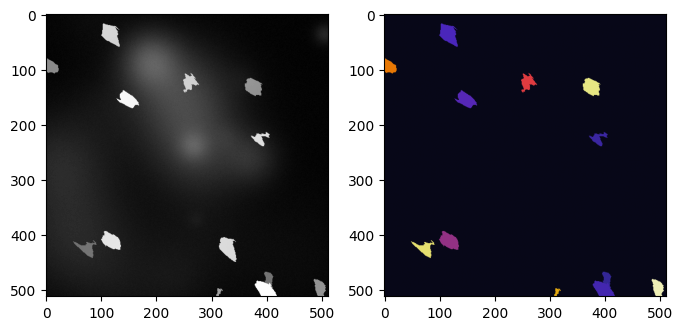

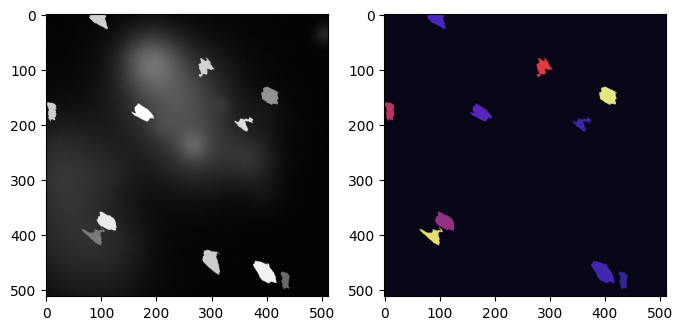

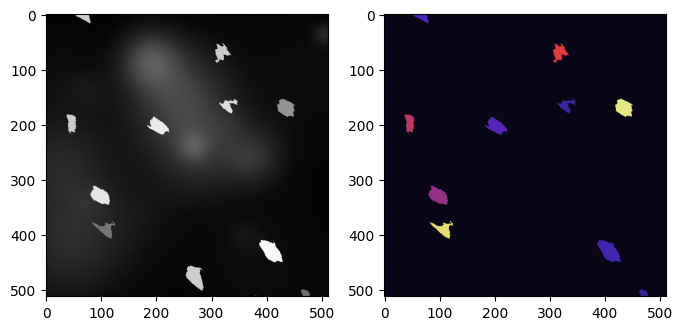

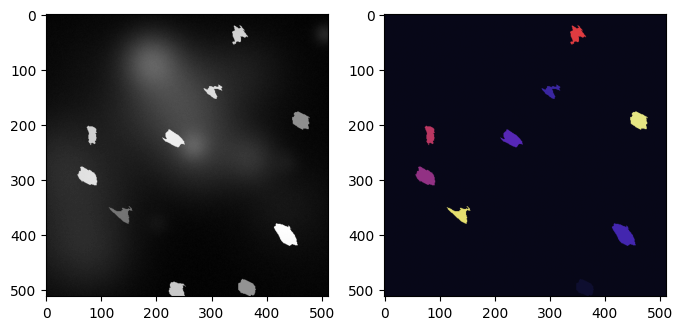

In [10]:
#@title Display generated dataset

for t in range(10):
  img, label = arrows.render()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
  ax1.imshow(img, cmap='gray')
  ax2.imshow(color_labels(label, max_id = init_objects))
  plt.show()
  print()

  arrows.step()

In [11]:
#@title Save generated dataset as video

def generate_frames(arrows, init_objects, num_frames):
    frames = []
    for _ in range(num_frames):
        img, label = arrows.render()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.imshow(img, cmap='gray')
        ax2.imshow(color_labels(label, max_id = init_objects))

        fig.canvas.draw()  # Draw the figure to update the plot
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        frames.append(frame)

        arrows.step()

    return frames

frames = generate_frames(arrows, init_objects, num_frames=100)

height, width, _ = frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('arrows_video.mp4', fourcc, 25.0, (width, height))

for frame in frames:
    out.write(frame)

out.release()

In [ ]:
#@title Generate Dataset

train_root = './SyntheticAmoeboids_train_samples/'
test_root = './SyntheticAmoeboids_test_samples/'

if os.path.exists(train_root):
  shutil.rmtree(train_root)
os.makedirs(train_root)

if os.path.exists(test_root):
  shutil.rmtree(test_root)
os.makedirs(test_root)

for sample_id in range(1,81):
  sample_folder = os.path.join(train_root, f"{sample_id:03d}/")
  imgs_folder = os.path.join(sample_folder, "imgs/")
  label_folder = os.path.join(sample_folder, "labels/")
  os.makedirs(sample_folder)
  os.makedirs(imgs_folder)
  os.makedirs(label_folder)

  init_objects = random.randint(30,50)
  arrows = SyntheticAmoeboids(init_objects = init_objects)
  for t in range(100):
    img, label = arrows.render()
    img = Image.fromarray(img)
    label = Image.fromarray(label)
    img.save(os.path.join(imgs_folder, f"{sample_id:03d}_{t:03d}_img.png"))
    label.save(os.path.join(label_folder, f"{sample_id:03d}_{t:03d}_label.png"))
    arrows.step()
  print(f"Train Sample {sample_id:03d} generated")

for sample_id in range(81,101):
  sample_folder = os.path.join(test_root, f"{sample_id:03d}/")
  imgs_folder = os.path.join(sample_folder, "imgs/")
  label_folder = os.path.join(sample_folder, "labels/")
  os.makedirs(sample_folder)
  os.makedirs(imgs_folder)
  os.makedirs(label_folder)

  init_objects = random.randint(30,50)
  arrows = SyntheticAmoeboids(init_objects = init_objects)
  for t in range(100):
    img, label = arrows.render()
    img = Image.fromarray(img)
    label = Image.fromarray(label)
    img.save(os.path.join(imgs_folder, f"{sample_id:03d}_{t:03d}_img.png"))
    label.save(os.path.join(label_folder, f"{sample_id:03d}_{t:03d}_label.png"))
    arrows.step()
  print(f"Test Sample {sample_id:03d} generated")

In [ ]:
!zip -r SyntheticAmoeboids_train_samples.zip ./SyntheticAmoeboids_train_samples
!zip -r SyntheticAmoeboids_test_samples.zip ./SyntheticAmoeboids_test_samples

In [ ]:
!unzip -t SyntheticAmoeboids_train_samples.zip
!unzip -t SyntheticAmoeboids_test_samples.zip

In [18]:
from google.colab import files
files.download('SyntheticAmoeboids_train_samples.zip')
files.download('SyntheticAmoeboids_test_samples.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>